In [1]:
#import all necessary liberty

import random

%matplotlib inline
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

import pandas as pd


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
#from sklearn.utils import shuffle
import csv

#spliting dataset into traning set and test set
from sklearn.model_selection import train_test_split
#missing value handle
from sklearn.preprocessing import Imputer
#To shuffle the data set
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import itertools

from scipy.stats import zscore

import os


Using TensorFlow backend.


In [2]:
os.environ['PYTHONHASHSEED'] = '0'

tf.set_random_seed(23)
np.random.seed(37)
random.seed(21)

In [42]:
class Neural_Network:
    data_frame = []
    df_after_shuffle = []
    data_set = []
    len_of_data_frame = []
    actual_x = []
    actual_y = []
    test_x = []
    test_y = []
    train_x = []
    train_y = []
    predicted_result = []
    rounded_predicted_result = []
    kfold_validation_score_store = []
    input_shape = 0
    learning_rate = .0001
    best_score = 0.0
    score = []
    cm = []
    
    def __init__(self,file_name):
        self.data_frame = pd.read_csv(file_name, sep='\t')
        self.len_of_data_frame = len(self.data_frame)
        self.input_shape = len(self.data_frame.columns)-1
        
        self.shuffle_the_data()
        
        
    def shuffle_the_data(self):
        #shuffle the data set
        #np.random.seed(40)
        self.df_after_shuffle = self.data_frame.reindex(np.random.permutation(self.data_frame.index))
        self.df_after_shuffle.reset_index(inplace=True,drop=True)
        
        self.x_data_y_data_create()
    
    def x_data_y_data_create(self):
        self.data_set = self.df_after_shuffle.values
        self.actual_x = self.data_set[:,:self.input_shape]
        self.actual_y = self.data_set[:,self.input_shape:]
        
    
    def cross_validation_model_training(self,n_Of_fold=10):
        kf = KFold(n_Of_fold)
        fold = 0
        #self.best_score = self.score
        terget_names = ["NO","YES"]
        
        for train,test in kf.split(self.actual_x):
            fold += 1
            print("fold #{}".format(fold))
            self.train_x = self.actual_x[train]
            self.train_y = self.actual_y[train]
            self.test_x = self.actual_x[test]
            self.test_y = self.actual_y[test]
            
            model = Sequential([
            Dense(8,input_shape=(self.input_shape,),activation="relu"),
            Dense(7,activation="relu"),
            Dense(6,activation="relu"),
            Dense(2,activation="softmax")
            ])

            model.compile(
                Adam(lr=self.learning_rate),loss='sparse_categorical_crossentropy',metrics=['accuracy']
            )
            
            
            model.fit(self.train_x, self.train_y,
                      validation_data = (self.test_x,self.test_y),
                      batch_size=10,epochs=100,shuffle=True,verbose=0)
            
            #model.save("heart_attack_risk_prediction_fold_no_"+str(fold)+"_with_cross_validation.h5")
            
            rounded_predections = model.predict_classes(self.test_x,batch_size=10,verbose=0)
            self.rounded_predicted_result = rounded_predections
            #pred = model.predict(self.test_x)
            pred_class = model.predict_classes(self.test_x)
            self.score = model.evaluate(self.test_x, self.test_y)
            
            if(self.best_score<self.score[1]):
                self.best_score = self.score[1]
                self.model = model
            
            self.kfold_validation_score_store.append(self.score)
            
            print("\nFold {0} score : {1}\n Score: {2}".format(fold,self.score,self.best_score))
            
            #print("\n\n")
            
            self.confussion_matrix_generator()
            self.ROC_curve_generator()
            
            print(classification_report(pred_class,self.test_y,target_names=terget_names))
            
            self.performance()
            
            #print("\n\nnew\n\n")
            #break
        else:
            self.save_model("cross_validation")
        
    def create_model(self):
        model = Sequential([
        Dense(8,input_shape=(self.input_shape,),activation="relu"),
        Dense(7,activation="relu"),
        Dense(6,activation="relu"),
        Dense(2,activation="softmax")
        ])

        model.compile(
            Adam(lr=self.learning_rate),loss='sparse_categorical_crossentropy',metrics=['accuracy']
        )
        
        self.model = model
    
    def split_data(self):
        # split into train and test sets
        train_size = int(len(self.data_set) * 0.80)
        test_size = len(self.data_set) - train_size   
        train, test = self.data_set[0:train_size,:], self.data_set[train_size:len(self.data_set),:]
        
        self.train_x = train[:,:self.input_shape]
        self.train_y = train[:,self.input_shape:]

        self.test_x = test[:,:self.input_shape]
        self.test_y = test[:,self.input_shape:]

        print(len(train), len(test))
    
    def percent_split_model_traning(self):
        self.shuffle_the_data()
        self.split_data()
        self.model.fit(self.train_x, self.train_y,
                  validation_data = (self.test_x,self.test_y),
                  batch_size=10,epochs=100,shuffle=True,verbose=2)
        #self.save_model("percent_split")
        
        
        
    def model_performance(self,test_x=[],test_y=[]):
        if(test_x==[] and test_y==[]):
            test_x=self.test_x
            test_y=self.test_y
        else:
            self.test_x=test_x
            self.test_y=test_y
        
        rounded_predections = self.model.predict_classes(test_x,batch_size=10,verbose=0)
        self.rounded_predicted_result = rounded_predections
        #pred = model.predict(self.test_x)
        pred_class = rounded_predections
        self.score = self.model.evaluate(test_x, test_y)
        
        self.confussion_matrix_generator()
        self.ROC_curve_generator()
        
        terget_names = ["NO","YES"]
        print(classification_report(pred_class,test_y,target_names=terget_names))

        self.performance()
        
            
    def ROC_curve_generator(self):
        #ROC curve

        # calculate the fpr and tpr for all thresholds of the classification
        probs = self.model.predict_proba(self.test_x)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(self.test_y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        # method I: plt
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def confussion_matrix_generator(self):
        #rounded_predections = self.model.predict_classes(self.test_x,batch_size=10,verbose=0)
        cm = confusion_matrix(self.test_y,self.rounded_predicted_result)
        self.cm = cm
        cm_plot_labels = ['no side effects', 'have side effects']
        print(cm)
        #self.plot_confusion_matrix(cm,cm_plot_labels,title='Confussion Matrix')

        
    def plot_confusion_matrix(self,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        #print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
    def performance(self):
        TN = self.cm[0][0]
        FP = self.cm[0][1]
        FN = self.cm[1][0]
        TP = self.cm[1][1]
        
        n =TN+FP+FN+TP
        print("numer of total test sample: ",n)
        
        print("Model Score: ", self.score)
        
        accuracy = (TP+TN)/n
        print("accuracy: ",accuracy)

        missclassafication_rate = 1-accuracy
        print("missclassafication_rate: ",missclassafication_rate)

        sensitivity = TP/(TP+FN)
        print("Sensitivity/Recall: ",sensitivity)

        spasificity = TN/(TN+FP)
        print("Spacificity: ",spasificity)

        precition = TP/(FP+TP)
        print("Precition: ",precition)

        prevalence = (FN+TP)/n
        print("prevalence: ",prevalence)

        PPV = TP/(TP+FP)
        print("Positive Predicted Value: ",PPV)

        NPV = TN/(TN+FN)
        print("Negative Predicted Value: ",NPV)

        beta = 0.5
        f_score = 1/(beta*(1/precition)+(1-beta)*(1/sensitivity))
        print("F Score: ",f_score)
        
    def save_model(self,string):
        self.model.save("heart_attack_risk_prediction_"+string+".h5")
    
    def user_data_predict(self,data):
        data = np.expand_dims(data, axis=0)
        predections = self.model.predict_classes(data,batch_size=10,verbose=0)
        return predections[0]

In [29]:
nn = Neural_Network('data.tab')

In [30]:
nn.len_of_data_frame

798

In [25]:
nn.shuffle_the_data()

In [26]:
nn.create_model()

In [43]:
#percent split
nn = Neural_Network('data.tab')
nn.shuffle_the_data()
nn.create_model()
for i in range(10):
    #print(nn.data_frame.head(5))
    nn.percent_split_model_traning()
    print("\n\n")

638 160
Train on 638 samples, validate on 160 samples
Epoch 1/100
 - 2s - loss: 1.3253 - acc: 0.6034 - val_loss: 0.9209 - val_acc: 0.5750
Epoch 2/100
 - 0s - loss: 0.7801 - acc: 0.5737 - val_loss: 0.7648 - val_acc: 0.5188
Epoch 3/100
 - 0s - loss: 0.7443 - acc: 0.5219 - val_loss: 0.7603 - val_acc: 0.5188
Epoch 4/100
 - 0s - loss: 0.7407 - acc: 0.5219 - val_loss: 0.7571 - val_acc: 0.5188
Epoch 5/100
 - 0s - loss: 0.7373 - acc: 0.5329 - val_loss: 0.7527 - val_acc: 0.5063
Epoch 6/100
 - 0s - loss: 0.7335 - acc: 0.5486 - val_loss: 0.7481 - val_acc: 0.5000
Epoch 7/100
 - 0s - loss: 0.7313 - acc: 0.5235 - val_loss: 0.7460 - val_acc: 0.5125
Epoch 8/100
 - 0s - loss: 0.7297 - acc: 0.5486 - val_loss: 0.7414 - val_acc: 0.5125
Epoch 9/100
 - 0s - loss: 0.7253 - acc: 0.5564 - val_loss: 0.7380 - val_acc: 0.5063
Epoch 10/100
 - 0s - loss: 0.7224 - acc: 0.5455 - val_loss: 0.7375 - val_acc: 0.5500
Epoch 11/100
 - 0s - loss: 0.7178 - acc: 0.5345 - val_loss: 0.7341 - val_acc: 0.5563
Epoch 12/100
 - 0s -

Epoch 97/100
 - 0s - loss: 0.5263 - acc: 0.7665 - val_loss: 0.5336 - val_acc: 0.7688
Epoch 98/100
 - 0s - loss: 0.5242 - acc: 0.7680 - val_loss: 0.5355 - val_acc: 0.7375
Epoch 99/100
 - 0s - loss: 0.5228 - acc: 0.7759 - val_loss: 0.5308 - val_acc: 0.7750
Epoch 100/100
 - 0s - loss: 0.5220 - acc: 0.7727 - val_loss: 0.5283 - val_acc: 0.7750



638 160
Train on 638 samples, validate on 160 samples
Epoch 1/100
 - 0s - loss: 0.5177 - acc: 0.7821 - val_loss: 0.5383 - val_acc: 0.7562
Epoch 2/100
 - 0s - loss: 0.5151 - acc: 0.7806 - val_loss: 0.5375 - val_acc: 0.7562
Epoch 3/100
 - 0s - loss: 0.5136 - acc: 0.7853 - val_loss: 0.5366 - val_acc: 0.7500
Epoch 4/100
 - 0s - loss: 0.5116 - acc: 0.7790 - val_loss: 0.5345 - val_acc: 0.7562
Epoch 5/100
 - 0s - loss: 0.5093 - acc: 0.7821 - val_loss: 0.5327 - val_acc: 0.7625
Epoch 6/100
 - 0s - loss: 0.5081 - acc: 0.7806 - val_loss: 0.5382 - val_acc: 0.7625
Epoch 7/100
 - 0s - loss: 0.5063 - acc: 0.7884 - val_loss: 0.5302 - val_acc: 0.7562
Epoch 8/100
 -

Epoch 93/100
 - 0s - loss: 0.4089 - acc: 0.8621 - val_loss: 0.4665 - val_acc: 0.8125
Epoch 94/100
 - 0s - loss: 0.4091 - acc: 0.8574 - val_loss: 0.4662 - val_acc: 0.8187
Epoch 95/100
 - 0s - loss: 0.4086 - acc: 0.8574 - val_loss: 0.4728 - val_acc: 0.8125
Epoch 96/100
 - 0s - loss: 0.4084 - acc: 0.8574 - val_loss: 0.4658 - val_acc: 0.8125
Epoch 97/100
 - 0s - loss: 0.4074 - acc: 0.8621 - val_loss: 0.4647 - val_acc: 0.8187
Epoch 98/100
 - 0s - loss: 0.4057 - acc: 0.8621 - val_loss: 0.4674 - val_acc: 0.8062
Epoch 99/100
 - 0s - loss: 0.4042 - acc: 0.8589 - val_loss: 0.4632 - val_acc: 0.8062
Epoch 100/100
 - 0s - loss: 0.4069 - acc: 0.8589 - val_loss: 0.4641 - val_acc: 0.8125



638 160
Train on 638 samples, validate on 160 samples
Epoch 1/100
 - 0s - loss: 0.4136 - acc: 0.8542 - val_loss: 0.4266 - val_acc: 0.8437
Epoch 2/100
 - 0s - loss: 0.4112 - acc: 0.8558 - val_loss: 0.4256 - val_acc: 0.8250
Epoch 3/100
 - 0s - loss: 0.4130 - acc: 0.8464 - val_loss: 0.4276 - val_acc: 0.8500
Epoch 4/10

Epoch 89/100
 - 0s - loss: 0.3859 - acc: 0.8542 - val_loss: 0.4123 - val_acc: 0.8250
Epoch 90/100
 - 0s - loss: 0.3861 - acc: 0.8527 - val_loss: 0.4129 - val_acc: 0.8312
Epoch 91/100
 - 0s - loss: 0.3874 - acc: 0.8527 - val_loss: 0.4137 - val_acc: 0.8250
Epoch 92/100
 - 0s - loss: 0.3848 - acc: 0.8542 - val_loss: 0.4154 - val_acc: 0.8250
Epoch 93/100
 - 0s - loss: 0.3858 - acc: 0.8558 - val_loss: 0.4147 - val_acc: 0.8312
Epoch 94/100
 - 0s - loss: 0.3849 - acc: 0.8574 - val_loss: 0.4130 - val_acc: 0.8250
Epoch 95/100
 - 0s - loss: 0.3850 - acc: 0.8542 - val_loss: 0.4127 - val_acc: 0.8250
Epoch 96/100
 - 0s - loss: 0.3848 - acc: 0.8558 - val_loss: 0.4159 - val_acc: 0.8312
Epoch 97/100
 - 0s - loss: 0.3853 - acc: 0.8558 - val_loss: 0.4137 - val_acc: 0.8250
Epoch 98/100
 - 0s - loss: 0.3845 - acc: 0.8574 - val_loss: 0.4131 - val_acc: 0.8250
Epoch 99/100
 - 0s - loss: 0.3841 - acc: 0.8574 - val_loss: 0.4123 - val_acc: 0.8250
Epoch 100/100
 - 0s - loss: 0.3860 - acc: 0.8558 - val_loss: 0.41

Epoch 85/100
 - 0s - loss: 0.3857 - acc: 0.8495 - val_loss: 0.3861 - val_acc: 0.8437
Epoch 86/100
 - 0s - loss: 0.3873 - acc: 0.8542 - val_loss: 0.3847 - val_acc: 0.8375
Epoch 87/100
 - 0s - loss: 0.3863 - acc: 0.8480 - val_loss: 0.3836 - val_acc: 0.8437
Epoch 88/100
 - 0s - loss: 0.3892 - acc: 0.8495 - val_loss: 0.3847 - val_acc: 0.8437
Epoch 89/100
 - 0s - loss: 0.3881 - acc: 0.8527 - val_loss: 0.3843 - val_acc: 0.8437
Epoch 90/100
 - 0s - loss: 0.3878 - acc: 0.8527 - val_loss: 0.3844 - val_acc: 0.8437
Epoch 91/100
 - 0s - loss: 0.3854 - acc: 0.8495 - val_loss: 0.3858 - val_acc: 0.8437
Epoch 92/100
 - 0s - loss: 0.3864 - acc: 0.8495 - val_loss: 0.3857 - val_acc: 0.8437
Epoch 93/100
 - 0s - loss: 0.3846 - acc: 0.8542 - val_loss: 0.3846 - val_acc: 0.8437
Epoch 94/100
 - 0s - loss: 0.3843 - acc: 0.8495 - val_loss: 0.3864 - val_acc: 0.8437
Epoch 95/100
 - 0s - loss: 0.3851 - acc: 0.8542 - val_loss: 0.3844 - val_acc: 0.8437
Epoch 96/100
 - 0s - loss: 0.3854 - acc: 0.8495 - val_loss: 0.384

Epoch 81/100
 - 0s - loss: 0.3701 - acc: 0.8542 - val_loss: 0.4288 - val_acc: 0.8125
Epoch 82/100
 - 0s - loss: 0.3693 - acc: 0.8574 - val_loss: 0.4285 - val_acc: 0.8125
Epoch 83/100
 - 0s - loss: 0.3689 - acc: 0.8542 - val_loss: 0.4335 - val_acc: 0.8125
Epoch 84/100
 - 0s - loss: 0.3706 - acc: 0.8574 - val_loss: 0.4316 - val_acc: 0.8125
Epoch 85/100
 - 0s - loss: 0.3703 - acc: 0.8558 - val_loss: 0.4285 - val_acc: 0.8125
Epoch 86/100
 - 0s - loss: 0.3719 - acc: 0.8558 - val_loss: 0.4322 - val_acc: 0.8125
Epoch 87/100
 - 0s - loss: 0.3715 - acc: 0.8542 - val_loss: 0.4300 - val_acc: 0.8125
Epoch 88/100
 - 0s - loss: 0.3704 - acc: 0.8558 - val_loss: 0.4356 - val_acc: 0.8125
Epoch 89/100
 - 0s - loss: 0.3713 - acc: 0.8558 - val_loss: 0.4312 - val_acc: 0.8125
Epoch 90/100
 - 0s - loss: 0.3693 - acc: 0.8558 - val_loss: 0.4301 - val_acc: 0.8125
Epoch 91/100
 - 0s - loss: 0.3705 - acc: 0.8558 - val_loss: 0.4304 - val_acc: 0.8062
Epoch 92/100
 - 0s - loss: 0.3729 - acc: 0.8589 - val_loss: 0.434

Epoch 77/100
 - 0s - loss: 0.3796 - acc: 0.8480 - val_loss: 0.3800 - val_acc: 0.8562
Epoch 78/100
 - 0s - loss: 0.3791 - acc: 0.8448 - val_loss: 0.3887 - val_acc: 0.8562
Epoch 79/100
 - 0s - loss: 0.3774 - acc: 0.8448 - val_loss: 0.3827 - val_acc: 0.8562
Epoch 80/100
 - 0s - loss: 0.3782 - acc: 0.8464 - val_loss: 0.3863 - val_acc: 0.8437
Epoch 81/100
 - 0s - loss: 0.3809 - acc: 0.8448 - val_loss: 0.3961 - val_acc: 0.8562
Epoch 82/100
 - 0s - loss: 0.3844 - acc: 0.8448 - val_loss: 0.3926 - val_acc: 0.8562
Epoch 83/100
 - 0s - loss: 0.3797 - acc: 0.8527 - val_loss: 0.3820 - val_acc: 0.8562
Epoch 84/100
 - 0s - loss: 0.3809 - acc: 0.8433 - val_loss: 0.3826 - val_acc: 0.8562
Epoch 85/100
 - 0s - loss: 0.3784 - acc: 0.8448 - val_loss: 0.3807 - val_acc: 0.8625
Epoch 86/100
 - 0s - loss: 0.3787 - acc: 0.8433 - val_loss: 0.3946 - val_acc: 0.8562
Epoch 87/100
 - 0s - loss: 0.3786 - acc: 0.8448 - val_loss: 0.3820 - val_acc: 0.8625
Epoch 88/100
 - 0s - loss: 0.3767 - acc: 0.8464 - val_loss: 0.383

Epoch 73/100
 - 0s - loss: 0.3861 - acc: 0.8542 - val_loss: 0.3469 - val_acc: 0.8687
Epoch 74/100
 - 0s - loss: 0.3844 - acc: 0.8433 - val_loss: 0.3466 - val_acc: 0.8687
Epoch 75/100
 - 0s - loss: 0.3860 - acc: 0.8480 - val_loss: 0.3515 - val_acc: 0.8625
Epoch 76/100
 - 0s - loss: 0.3839 - acc: 0.8448 - val_loss: 0.3474 - val_acc: 0.8687
Epoch 77/100
 - 0s - loss: 0.3867 - acc: 0.8448 - val_loss: 0.3466 - val_acc: 0.8687
Epoch 78/100
 - 0s - loss: 0.3852 - acc: 0.8401 - val_loss: 0.3499 - val_acc: 0.8687
Epoch 79/100
 - 0s - loss: 0.3855 - acc: 0.8417 - val_loss: 0.3477 - val_acc: 0.8625
Epoch 80/100
 - 0s - loss: 0.3857 - acc: 0.8417 - val_loss: 0.3467 - val_acc: 0.8687
Epoch 81/100
 - 0s - loss: 0.3844 - acc: 0.8464 - val_loss: 0.3471 - val_acc: 0.8687
Epoch 82/100
 - 0s - loss: 0.3841 - acc: 0.8433 - val_loss: 0.3475 - val_acc: 0.8687
Epoch 83/100
 - 0s - loss: 0.3831 - acc: 0.8448 - val_loss: 0.3471 - val_acc: 0.8687
Epoch 84/100
 - 0s - loss: 0.3834 - acc: 0.8464 - val_loss: 0.353

Epoch 69/100
 - 0s - loss: 0.3605 - acc: 0.8605 - val_loss: 0.4414 - val_acc: 0.7875
Epoch 70/100
 - 0s - loss: 0.3622 - acc: 0.8589 - val_loss: 0.4384 - val_acc: 0.8000
Epoch 71/100
 - 0s - loss: 0.3616 - acc: 0.8589 - val_loss: 0.4384 - val_acc: 0.8000
Epoch 72/100
 - 0s - loss: 0.3588 - acc: 0.8589 - val_loss: 0.4396 - val_acc: 0.7875
Epoch 73/100
 - 0s - loss: 0.3639 - acc: 0.8558 - val_loss: 0.4409 - val_acc: 0.8000
Epoch 74/100
 - 0s - loss: 0.3607 - acc: 0.8589 - val_loss: 0.4376 - val_acc: 0.8000
Epoch 75/100
 - 0s - loss: 0.3602 - acc: 0.8589 - val_loss: 0.4400 - val_acc: 0.8000
Epoch 76/100
 - 0s - loss: 0.3592 - acc: 0.8589 - val_loss: 0.4366 - val_acc: 0.8000
Epoch 77/100
 - 0s - loss: 0.3586 - acc: 0.8605 - val_loss: 0.4382 - val_acc: 0.8000
Epoch 78/100
 - 0s - loss: 0.3588 - acc: 0.8574 - val_loss: 0.4376 - val_acc: 0.8000
Epoch 79/100
 - 0s - loss: 0.3590 - acc: 0.8589 - val_loss: 0.4393 - val_acc: 0.8000
Epoch 80/100
 - 0s - loss: 0.3609 - acc: 0.8589 - val_loss: 0.441

Epoch 65/100
 - 0s - loss: 0.3762 - acc: 0.8433 - val_loss: 0.3602 - val_acc: 0.8625
Epoch 66/100
 - 0s - loss: 0.3775 - acc: 0.8433 - val_loss: 0.3718 - val_acc: 0.8562
Epoch 67/100
 - 0s - loss: 0.3757 - acc: 0.8464 - val_loss: 0.3627 - val_acc: 0.8625
Epoch 68/100
 - 0s - loss: 0.3764 - acc: 0.8433 - val_loss: 0.3589 - val_acc: 0.8625
Epoch 69/100
 - 0s - loss: 0.3746 - acc: 0.8448 - val_loss: 0.3635 - val_acc: 0.8562
Epoch 70/100
 - 0s - loss: 0.3745 - acc: 0.8433 - val_loss: 0.3585 - val_acc: 0.8625
Epoch 71/100
 - 0s - loss: 0.3761 - acc: 0.8464 - val_loss: 0.3589 - val_acc: 0.8625
Epoch 72/100
 - 0s - loss: 0.3768 - acc: 0.8433 - val_loss: 0.3598 - val_acc: 0.8625
Epoch 73/100
 - 0s - loss: 0.3767 - acc: 0.8433 - val_loss: 0.3595 - val_acc: 0.8625
Epoch 74/100
 - 0s - loss: 0.3773 - acc: 0.8433 - val_loss: 0.3582 - val_acc: 0.8687
Epoch 75/100
 - 0s - loss: 0.3760 - acc: 0.8401 - val_loss: 0.3596 - val_acc: 0.8625
Epoch 76/100
 - 0s - loss: 0.3750 - acc: 0.8417 - val_loss: 0.359

Epoch 61/100
 - 0s - loss: 0.3563 - acc: 0.8589 - val_loss: 0.4275 - val_acc: 0.8000
Epoch 62/100
 - 0s - loss: 0.3575 - acc: 0.8605 - val_loss: 0.4254 - val_acc: 0.8000
Epoch 63/100
 - 0s - loss: 0.3586 - acc: 0.8527 - val_loss: 0.4375 - val_acc: 0.8375
Epoch 64/100
 - 0s - loss: 0.3603 - acc: 0.8589 - val_loss: 0.4300 - val_acc: 0.8375
Epoch 65/100
 - 0s - loss: 0.3554 - acc: 0.8558 - val_loss: 0.4259 - val_acc: 0.8000
Epoch 66/100
 - 0s - loss: 0.3555 - acc: 0.8574 - val_loss: 0.4275 - val_acc: 0.8000
Epoch 67/100
 - 0s - loss: 0.3569 - acc: 0.8589 - val_loss: 0.4244 - val_acc: 0.7937
Epoch 68/100
 - 0s - loss: 0.3544 - acc: 0.8605 - val_loss: 0.4328 - val_acc: 0.8375
Epoch 69/100
 - 0s - loss: 0.3575 - acc: 0.8542 - val_loss: 0.4275 - val_acc: 0.8125
Epoch 70/100
 - 0s - loss: 0.3562 - acc: 0.8574 - val_loss: 0.4340 - val_acc: 0.8375
Epoch 71/100
 - 0s - loss: 0.3574 - acc: 0.8574 - val_loss: 0.4301 - val_acc: 0.8312
Epoch 72/100
 - 0s - loss: 0.3549 - acc: 0.8574 - val_loss: 0.426

160/160 [==============================] - 0s 31us/step
[[47 20]
 [ 4 89]]


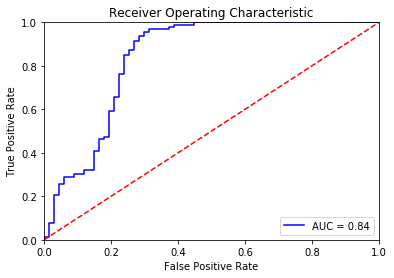

              precision    recall  f1-score   support

          NO       0.70      0.92      0.80        51
         YES       0.96      0.82      0.88       109

   micro avg       0.85      0.85      0.85       160
   macro avg       0.83      0.87      0.84       160
weighted avg       0.88      0.85      0.85       160

numer of total test sample:  160
Model Score:  [0.4113450586795807, 0.85]
accuracy:  0.85
missclassafication_rate:  0.15000000000000002
Sensitivity/Recall:  0.956989247311828
Spacificity:  0.7014925373134329
Precition:  0.8165137614678899
prevalence:  0.58125
Positive Predicted Value:  0.8165137614678899
Negative Predicted Value:  0.9215686274509803
F Score:  0.8811881188118813


In [32]:
nn.model_performance()

In [35]:
nn.model_performance(nn.actual_x,nn.actual_y)

/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


ValueError: Error when checking input: expected dense_37_input to have shape (13,) but got array with shape (14,)

In [18]:
nn.save_model("percent_split")

In [11]:
nn.user_data_predict([50, 1,0,1,0,1,0,1,1,1,1,0,0,0])

0

In [ ]:
nn.user_data_predict([32, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

fold #1
80/80 [==============================] - 0s 38us/step

Fold 1 score : [0.6101382374763489, 0.65]
 Score: 0.65
[[ 6 28]
 [ 0 46]]


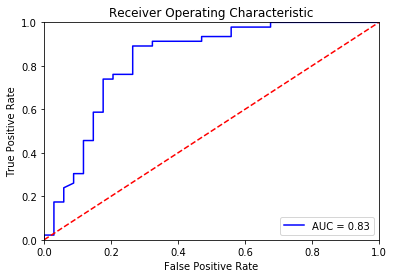

              precision    recall  f1-score   support

          NO       0.18      1.00      0.30         6
         YES       1.00      0.62      0.77        74

   micro avg       0.65      0.65      0.65        80
   macro avg       0.59      0.81      0.53        80
weighted avg       0.94      0.65      0.73        80

numer of total test sample:  80
Model Score:  [0.6101382374763489, 0.65]
accuracy:  0.65
missclassafication_rate:  0.35
Sensitivity/Recall:  1.0
Spacificity:  0.17647058823529413
Precition:  0.6216216216216216
prevalence:  0.575
Positive Predicted Value:  0.6216216216216216
Negative Predicted Value:  1.0
F Score:  0.7666666666666666
fold #2
80/80 [==============================] - 0s 46us/step

Fold 2 score : [0.45172858238220215, 0.8]
 Score: 0.8
[[18 11]
 [ 5 46]]


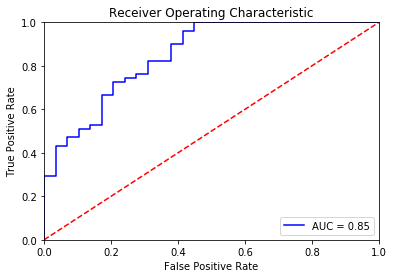

              precision    recall  f1-score   support

          NO       0.62      0.78      0.69        23
         YES       0.90      0.81      0.85        57

   micro avg       0.80      0.80      0.80        80
   macro avg       0.76      0.79      0.77        80
weighted avg       0.82      0.80      0.81        80

numer of total test sample:  80
Model Score:  [0.45172858238220215, 0.8]
accuracy:  0.8
missclassafication_rate:  0.19999999999999996
Sensitivity/Recall:  0.9019607843137255
Spacificity:  0.6206896551724138
Precition:  0.8070175438596491
prevalence:  0.6375
Positive Predicted Value:  0.8070175438596491
Negative Predicted Value:  0.782608695652174
F Score:  0.8518518518518517
fold #3
80/80 [==============================] - 0s 43us/step

Fold 3 score : [0.4285730540752411, 0.825]
 Score: 0.825
[[20  9]
 [ 5 46]]


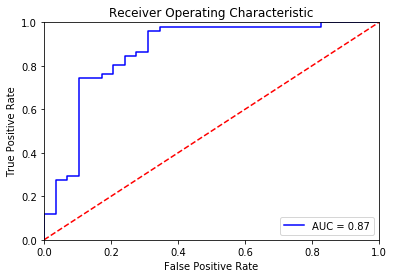

              precision    recall  f1-score   support

          NO       0.69      0.80      0.74        25
         YES       0.90      0.84      0.87        55

   micro avg       0.82      0.82      0.82        80
   macro avg       0.80      0.82      0.80        80
weighted avg       0.84      0.82      0.83        80

numer of total test sample:  80
Model Score:  [0.4285730540752411, 0.825]
accuracy:  0.825
missclassafication_rate:  0.17500000000000004
Sensitivity/Recall:  0.9019607843137255
Spacificity:  0.6896551724137931
Precition:  0.8363636363636363
prevalence:  0.6375
Positive Predicted Value:  0.8363636363636363
Negative Predicted Value:  0.8
F Score:  0.8679245283018868
fold #4
80/80 [==============================] - 0s 44us/step

Fold 4 score : [0.6792235493659973, 0.575]
 Score: 0.825
[[ 4 33]
 [ 1 42]]


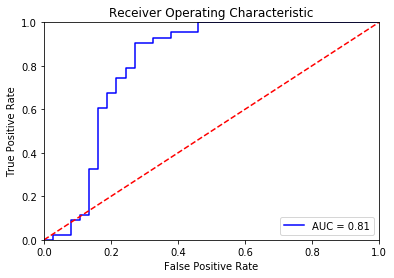

              precision    recall  f1-score   support

          NO       0.11      0.80      0.19         5
         YES       0.98      0.56      0.71        75

   micro avg       0.57      0.57      0.57        80
   macro avg       0.54      0.68      0.45        80
weighted avg       0.92      0.58      0.68        80

numer of total test sample:  80
Model Score:  [0.6792235493659973, 0.575]
accuracy:  0.575
missclassafication_rate:  0.42500000000000004
Sensitivity/Recall:  0.9767441860465116
Spacificity:  0.10810810810810811
Precition:  0.56
prevalence:  0.5375
Positive Predicted Value:  0.56
Negative Predicted Value:  0.8
F Score:  0.7118644067796611
fold #5
80/80 [==============================] - 0s 104us/step

Fold 5 score : [0.4602179527282715, 0.825]
 Score: 0.825
[[23 11]
 [ 3 43]]


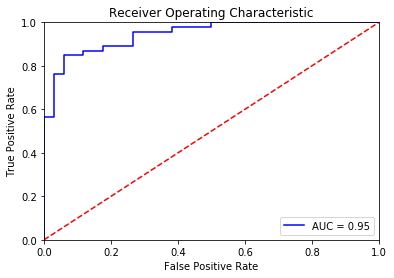

              precision    recall  f1-score   support

          NO       0.68      0.88      0.77        26
         YES       0.93      0.80      0.86        54

   micro avg       0.82      0.82      0.82        80
   macro avg       0.81      0.84      0.81        80
weighted avg       0.85      0.82      0.83        80

numer of total test sample:  80
Model Score:  [0.4602179527282715, 0.825]
accuracy:  0.825
missclassafication_rate:  0.17500000000000004
Sensitivity/Recall:  0.9347826086956522
Spacificity:  0.6764705882352942
Precition:  0.7962962962962963
prevalence:  0.575
Positive Predicted Value:  0.7962962962962963
Negative Predicted Value:  0.8846153846153846
F Score:  0.8600000000000001
fold #6
80/80 [==============================] - 0s 46us/step

Fold 6 score : [0.5794959783554077, 0.7625]
 Score: 0.825
[[14 18]
 [ 1 47]]


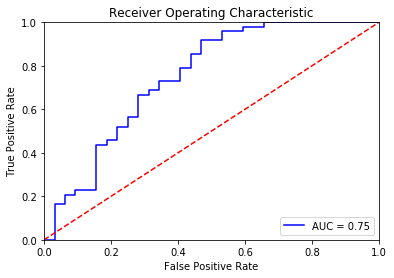

              precision    recall  f1-score   support

          NO       0.44      0.93      0.60        15
         YES       0.98      0.72      0.83        65

   micro avg       0.76      0.76      0.76        80
   macro avg       0.71      0.83      0.71        80
weighted avg       0.88      0.76      0.79        80

numer of total test sample:  80
Model Score:  [0.5794959783554077, 0.7625]
accuracy:  0.7625
missclassafication_rate:  0.23750000000000004
Sensitivity/Recall:  0.9791666666666666
Spacificity:  0.4375
Precition:  0.7230769230769231
prevalence:  0.6
Positive Predicted Value:  0.7230769230769231
Negative Predicted Value:  0.9333333333333333
F Score:  0.8318584070796459
fold #7
80/80 [==============================] - 0s 46us/step

Fold 7 score : [0.5093850791454315, 0.8]
 Score: 0.825
[[20 11]
 [ 5 44]]


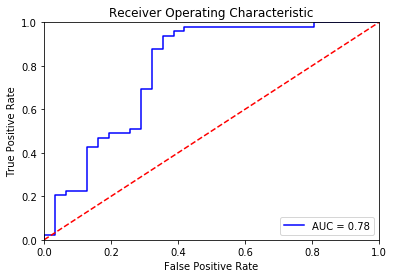

              precision    recall  f1-score   support

          NO       0.65      0.80      0.71        25
         YES       0.90      0.80      0.85        55

   micro avg       0.80      0.80      0.80        80
   macro avg       0.77      0.80      0.78        80
weighted avg       0.82      0.80      0.80        80

numer of total test sample:  80
Model Score:  [0.5093850791454315, 0.8]
accuracy:  0.8
missclassafication_rate:  0.19999999999999996
Sensitivity/Recall:  0.8979591836734694
Spacificity:  0.6451612903225806
Precition:  0.8
prevalence:  0.6125
Positive Predicted Value:  0.8
Negative Predicted Value:  0.8
F Score:  0.8461538461538463
fold #8
80/80 [==============================] - 0s 57us/step

Fold 8 score : [0.4681002736091614, 0.8375]
 Score: 0.8375
[[15  9]
 [ 4 52]]


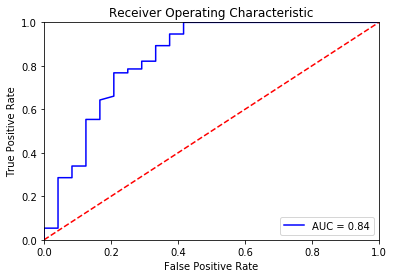

              precision    recall  f1-score   support

          NO       0.62      0.79      0.70        19
         YES       0.93      0.85      0.89        61

   micro avg       0.84      0.84      0.84        80
   macro avg       0.78      0.82      0.79        80
weighted avg       0.86      0.84      0.84        80

numer of total test sample:  80
Model Score:  [0.4681002736091614, 0.8375]
accuracy:  0.8375
missclassafication_rate:  0.16249999999999998
Sensitivity/Recall:  0.9285714285714286
Spacificity:  0.625
Precition:  0.8524590163934426
prevalence:  0.7
Positive Predicted Value:  0.8524590163934426
Negative Predicted Value:  0.7894736842105263
F Score:  0.8888888888888888
fold #9
79/79 [==============================] - 0s 138us/step

Fold 9 score : [0.7022178784201417, 0.5316455741471882]
 Score: 0.8375
[[ 0 37]
 [ 0 42]]


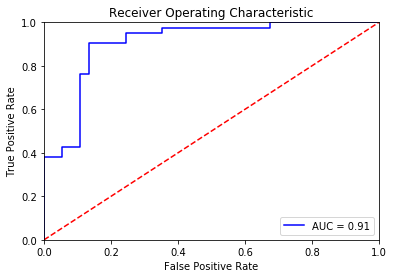

/home/sakib/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:260: RuntimeWarning: invalid value encountered in long_scalars


              precision    recall  f1-score   support

          NO       0.00      0.00      0.00         0
         YES       1.00      0.53      0.69        79

   micro avg       0.53      0.53      0.53        79
   macro avg       0.50      0.27      0.35        79
weighted avg       1.00      0.53      0.69        79

numer of total test sample:  79
Model Score:  [0.7022178784201417, 0.5316455741471882]
accuracy:  0.5316455696202531
missclassafication_rate:  0.4683544303797469
Sensitivity/Recall:  1.0
Spacificity:  0.0
Precition:  0.5316455696202531
prevalence:  0.5316455696202531
Positive Predicted Value:  0.5316455696202531
Negative Predicted Value:  nan
F Score:  0.6942148760330578
fold #10
79/79 [==============================] - 0s 58us/step

Fold 10 score : [0.47162997383105604, 0.8354430387291727]
 Score: 0.8375
[[23 11]
 [ 2 43]]


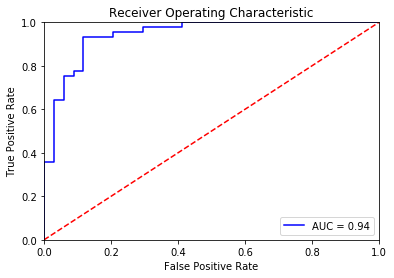

              precision    recall  f1-score   support

          NO       0.68      0.92      0.78        25
         YES       0.96      0.80      0.87        54

   micro avg       0.84      0.84      0.84        79
   macro avg       0.82      0.86      0.82        79
weighted avg       0.87      0.84      0.84        79

numer of total test sample:  79
Model Score:  [0.47162997383105604, 0.8354430387291727]
accuracy:  0.8354430379746836
missclassafication_rate:  0.16455696202531644
Sensitivity/Recall:  0.9555555555555556
Spacificity:  0.6764705882352942
Precition:  0.7962962962962963
prevalence:  0.569620253164557
Positive Predicted Value:  0.7962962962962963
Negative Predicted Value:  0.92
F Score:  0.8686868686868688


In [36]:
#cross valodation
nnc = Neural_Network('data.tab')
nnc.shuffle_the_data()
nnc.cross_validation_model_training()

In [37]:
nnc.best_score

0.8375

In [38]:
nnc.kfold_validation_score_store

[[0.6101382374763489, 0.65],
 [0.45172858238220215, 0.8],
 [0.4285730540752411, 0.825],
 [0.6792235493659973, 0.575],
 [0.4602179527282715, 0.825],
 [0.5794959783554077, 0.7625],
 [0.5093850791454315, 0.8],
 [0.4681002736091614, 0.8375],
 [0.7022178784201417, 0.5316455741471882],
 [0.47162997383105604, 0.8354430387291727]]

In [93]:
#nn.model.get_weights()

In [40]:
nnc.model.evaluate(nn.test_x,nn.test_y)

ValueError: Error when checking input: expected dense_69_input to have shape (13,) but got array with shape (14,)

In [41]:
nn.model.evaluate(nn.actual_x,nn.actual_y)

ValueError: Error when checking input: expected dense_37_input to have shape (13,) but got array with shape (14,)